In [1]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

In [8]:
football = Table.read_table('deflategate.csv')
football

# 11 patriots balls, only 4 colts footballs
# what else would you want to know about this data to analyze
# whether the patriots balls were deflated?

# NFL standard: 12.5 - 13.5 psi at beginning of game
# balls do deflate over the cuorse of the game

Team,Blakeman,Prioleau
Patriots,11.5,11.8
Patriots,10.85,11.2
Patriots,11.15,11.5
Patriots,10.7,11
Patriots,11.1,11.45
Patriots,11.6,11.95
Patriots,11.85,12.3
Patriots,11.1,11.55
Patriots,10.95,11.35
Patriots,10.5,10.9


In [7]:
# what's the average by team?
average_pressures = football.group('Team',np.mean)
average_pressures

Team,Blakeman mean,Prioleau mean
Colts,12.625,12.4375
Patriots,11.1091,11.4864


In [11]:
# how different are the measurements by official?
average_by_official = (football.column(1) + football.column(2)) / 2
football = football.with_column('Average at Half',average_by_official)
football.show()

Team,Blakeman,Prioleau,Average at Half
Patriots,11.5,11.8,11.65
Patriots,10.85,11.2,11.025
Patriots,11.15,11.5,11.325
Patriots,10.7,11,10.85
Patriots,11.1,11.45,11.275
Patriots,11.6,11.95,11.775
Patriots,11.85,12.3,12.075
Patriots,11.1,11.55,11.325
Patriots,10.95,11.35,11.15
Patriots,10.5,10.9,10.7


In [12]:
# but the balls *started* at different pressures
# then they deflate
# so we need to actually measure the *drop* from initial pressure

# patriots started at 12.5, colts at 13
initials = np.append(np.ones(11) * 12.5, np.ones(4) * 13)
initials

array([12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5,
       13. , 13. , 13. , 13. ])

In [15]:
temp = football.with_column('Estimate at Start',initials)
temp.show()

Team,Blakeman,Prioleau,Average at Half,Estimate at Start
Patriots,11.5,11.8,11.65,12.5
Patriots,10.85,11.2,11.025,12.5
Patriots,11.15,11.5,11.325,12.5
Patriots,10.7,11,10.85,12.5
Patriots,11.1,11.45,11.275,12.5
Patriots,11.6,11.95,11.775,12.5
Patriots,11.85,12.3,12.075,12.5
Patriots,11.1,11.55,11.325,12.5
Patriots,10.95,11.35,11.15,12.5
Patriots,10.5,10.9,10.7,12.5


In [17]:
drop = temp.column(4) - temp.column(3)
temp = temp.with_column('drop',drop)
temp.show()

Team,Blakeman,Prioleau,Average at Half,Estimate at Start,drop
Patriots,11.5,11.8,11.65,12.5,0.85
Patriots,10.85,11.2,11.025,12.5,1.475
Patriots,11.15,11.5,11.325,12.5,1.175
Patriots,10.7,11,10.85,12.5,1.65
Patriots,11.1,11.45,11.275,12.5,1.225
Patriots,11.6,11.95,11.775,12.5,0.725
Patriots,11.85,12.3,12.075,12.5,0.425
Patriots,11.1,11.55,11.325,12.5,1.175
Patriots,10.95,11.35,11.15,12.5,1.35
Patriots,10.5,10.9,10.7,12.5,1.8


In [20]:
just_drops = temp.select('Team','drop')
just_drops.show()

Team,drop
Patriots,0.85
Patriots,1.475
Patriots,1.175
Patriots,1.65
Patriots,1.225
Patriots,0.725
Patriots,0.425
Patriots,1.175
Patriots,1.35
Patriots,1.8


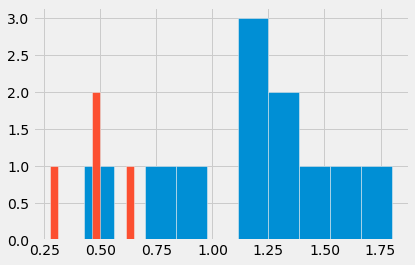

In [36]:
plots.hist(just_drops.where('Team','Patriots').column(1))
plots.hist(just_drops.where('Team','Colts').column(1))
plots.show()

In [ ]:
# how significant is this difference? how likely is it to happen by chance?

# null: the patriots and the colts drops came from the same distribution
# alternative: they didn't

# what's a good test statistic?

In [72]:
def diff_in_avgs(t):
    avg_drops = t.group('Team',np.average).column(1)
    return abs(avg_drops.item(0) - avg_drops.item(1))

observed = diff_in_avgs(just_drops)
observed

0.733522727272728

In [62]:
# how would you simulate assuming the null is true?
# back to slides
def shuffle_table(t):
    t2 = t.select('drop').sample(with_replacement=False)
    new_t = t.select('Team').with_column('drop',t2.column(0))
    return new_t

shuffle_table(just_drops)

Team,drop
Patriots,0.275
Patriots,0.475
Patriots,1.35
Patriots,0.475
Patriots,0.65
Patriots,1.225
Patriots,1.8
Patriots,1.475
Patriots,0.725
Patriots,1.65


In [74]:
null_stats = make_array()
repetitions = 10000

for r in range(repetitions):
    null_stats = np.append(null_stats,diff_in_avgs(shuffle_table(just_drops)))

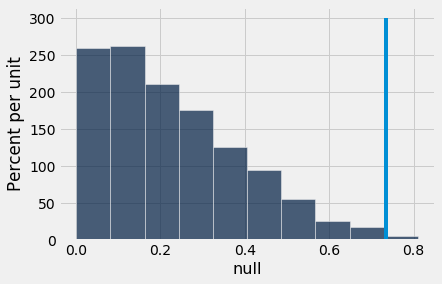

In [75]:
Table().with_column('null',null_stats).hist()
plots.plot([observed,observed],[0,3])

In [76]:
np.count_nonzero(null_stats >= observed) / repetitions

# by any reasonable p-value, this is significantly significant
# so we can reject the null

0.0047